# Analyze Region 5 - Greenland Periphery

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 5 - Greenland Periphery.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "5"
region_name = "Greenland Periphery"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # This is a guess from looking at literature (Luckman, 2003; Weidick, 1995)

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 4
region_index_2 = 5

# Ice cap/icefield epsg code used for calculating area
#ic_epsg = '3178' #'32627'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

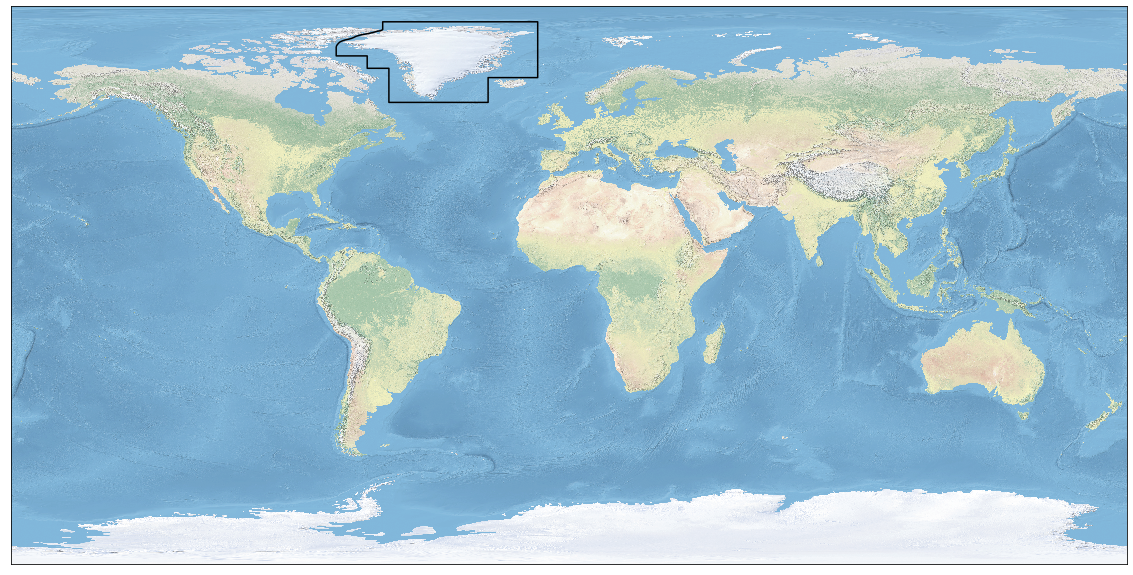

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny  maxx  maxy
4 -75.0  59.0 -10.0  85.0

# * * * * * * * * Glacier Analysis * * * * * * * *

For Greenland, need to filter the glaciers by those that have connectivity level 0 or 1. If they are level 2, it means they are too connected to the ice sheet and don't fit our definition of glacier in this project. Only RGI contains this connectivity metadata. So filtered RGI for glaciers with 0 or 1 connectivity and now cross referencing them to GLIMS.

1. RGI ID: RGI60-05.10749, GLIMS ID: G322065E82674N
2. RGI ID: RGI60-05.00459, GLIMS ID: G309162E65933N
3. RGI ID: RGI60-05.13995, GLIMS ID: G323748E66257N

## Open RGI 3 Largest Glaciers Data

In [7]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [8]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 0 equals none
RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 3 equals none
RGI glacier 4 equals none


In [9]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-05.10315  G344790E81287N  20010703  -9999999 -15.2101  81.2869   
1  RGI60-05.10749  G322065E82674N  19999999  20049999 -37.9353  82.6735   
2  RGI60-05.00459  G309162E65933N  20000823  -9999999 -50.8380  65.9328   
3  RGI60-05.13995  G323748E66257N  20000909  -9999999 -36.2521  66.2572   
4  RGI60-05.00460  G308629E65949N  20000823  -9999999 -51.3711  65.9493   

  O1Region O2Region      Area  Zmin  ...  Aspect   Lmax  Status  Connect  \
0        5        1  7537.579    32  ...      63   3890       0        0   
1        5        1   738.938    32  ...     300  40508       0        0   
2        5        1   600.409    91  ...     168  48018       0        1   
3        5        1   582.810    60  ...     215  50953       0        1   
4        5        1   573.547    36  ...     220  35910       0        1   

   Form  TermType  Surging  Linkages  Name  \
0     0         1        9         9  NONE   
1     1         1        9         9  NONE   
2     1         0        9         9  NONE   
3     0         1        9         9  NONE   
4     0         1        9         9  NONE   

                                            geometry  
0  POLYGON ((-14.16361495199993 81.29903210400005...  
1  POLYGON ((-38.37329431199998 82.88780234700005...  
2  POLYGON ((-51.00189210799994 66.05496811200004...  
3  POLYGON ((-36.20135722999993 66.40701665400007...  
4  POLYGON ((-51.25995569099996 66.08669195300007...  

[5 rows x 23 columns]

## Open GLIMS 3 Largest Glaciers Data

This section is different from other regions because I need to use the glacier IDs I filtered from RGI for this. This section is also usually before the Open RGI data section, however, since I need the GLIMS IDs out of the RGI data, swapping these two secctions around.

In [10]:
# Open GLIMS region 5 cleaned data file and search for the apprpriate glaciers by ID filtered from RGI
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_5_cleaned.shp"
glims_glaciers_all_df = gpd.read_file(glims_glaciers_fn)

In [11]:
# Find the GLIMS records from the GLIMS IDS in the RGI dataframe. This means that I'm finding the glaciers that
# connectivity of 0 or 1 based on the RGI dataframe that was filtered for this in notebook 4-compare-glims-rgi.ipynb
glims_ids = [rgi_glaciers_df['GLIMSId'][1], rgi_glaciers_df['GLIMSId'][2], rgi_glaciers_df['GLIMSId'][3]]
for counter, x in enumerate(glims_ids):
    print(x)
    if counter == 0:
        # Set up first instance of dataframe so we can append to it later
        glims_glaciers_df = glims_glaciers_all_df[glims_glaciers_all_df['glac_id']==x]
    else:
        glims_glaciers_df_part = glims_glaciers_all_df[glims_glaciers_all_df['glac_id']==x]
        glims_glaciers_df = glims_glaciers_df.append(glims_glaciers_df_part)
    
glims_glaciers_df = glims_glaciers_df.reset_index(drop=True)

G322065E82674N
G309162E65933N
G323748E66257N


In [12]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [13]:
glims_glaciers_df

region_no         glac_id     area  db_area  width  length  primeclass  \
0          5  G322065E82674N  738.938  739.068    0.0     0.0         0.0   
1          5  G309162E65933N  600.409  607.232    0.0     0.0         0.0   
2          5  G323748E66257N  582.810  583.373    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date glac_name  \
0      32.0        0.0    1483.0  1999-09-01T00:00:00      None   
1      91.0        0.0    1780.0  2000-08-23T00:00:00      None   
2      60.0        0.0    1843.0  2000-09-09T00:00:00      None   

                                            geometry  
0  POLYGON Z ((-38.373294 82.88780199999999 0, -3...  
1  POLYGON Z ((-51.025265 66.02346199999999 0, -5...  
2  POLYGON Z ((-36.201357 66.407017 0, -36.201526...

## Plot GLIMS Glaciers

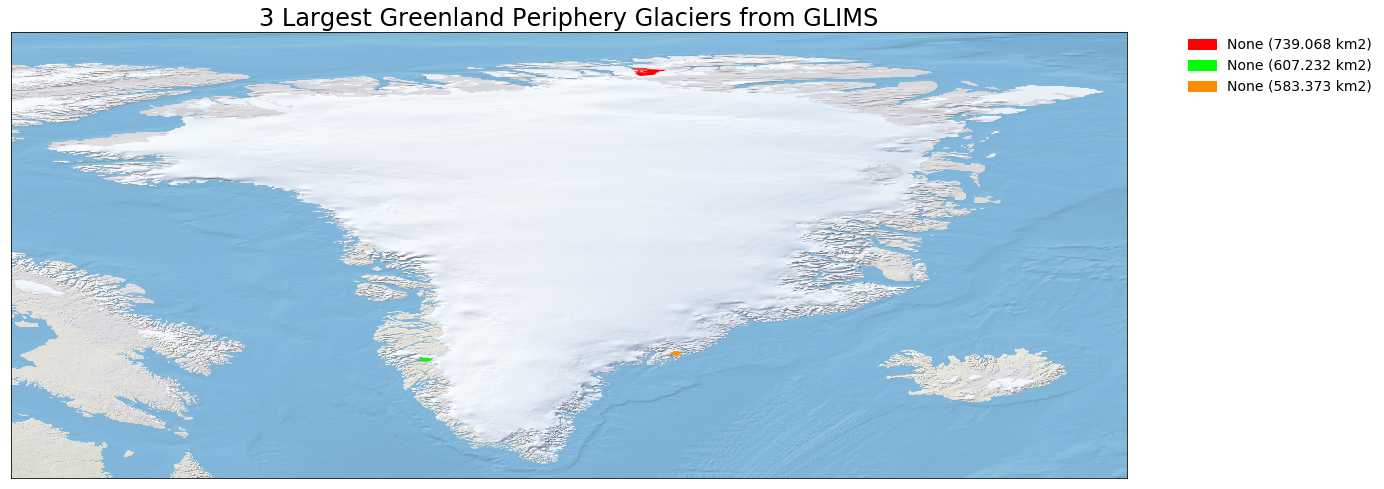

In [14]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Plot RGI Glaciers

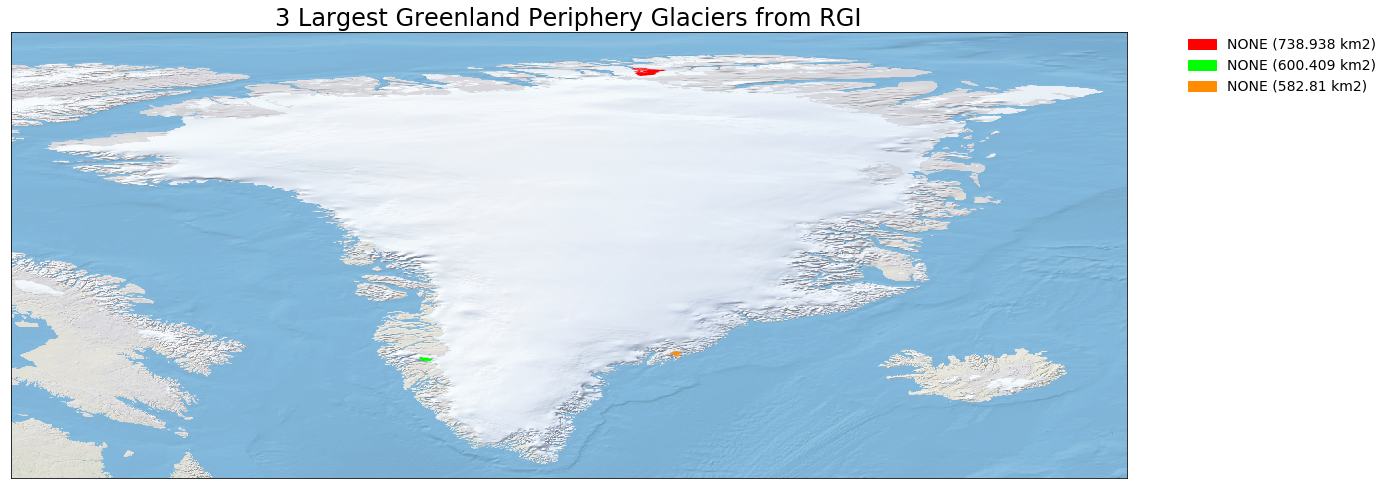

In [15]:
# Plot 3 largest glaciers on natural earth from RGI
# NOTE: Skipping 1st entry because it is an ice cap
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)',
                 rgi_glaciers_df['Name'][3] + ' (' + str(rgi_glaciers_df['Area'][3]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[3:4].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

For glaiciers with connectivity 0 or 1, here are the names that I've found:
1. largest (G322065E82674N) No real name that I can find. Perhaps call it Central Dome Glacier? (Zekollari, 2017). Andreas Peter said he thinks this is Tjalfe Glacier per Bjørk et al. (2015)
1. 2nd largest (G309162E65933N) Can't find a name. It's near the Amitsuloq ice cap and Taseriaq lake. Will just call it "Unnamed Glacier"
1. 3rd largest (G323748E66257N) From a photo in Google Earth, this is labeld as Knud Rasmussen Galcier

The notes below pertain to glaciers with connectivity level 2. As of 9/10/20, we have decided that only glaciers with connectivity level 0 or 1 will be considered. Thus, these notes are no longer pertinent. 
The largest in both GLIMS and RGI is an ice cap - Flade Islblink. Will need to skip this in the glacier section and use it in the ice cap section lower down.

The name of the 3rd largest in RGI is Magga Dan.

Deciding on the 3 largest to be Christian IV, Vestfjord, and Dendrit.

In [16]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final glacier dataframe

In [17]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop 1 st rows because its an ice cap and 5th row because we aren't interested in it
#final_glacier_data_df.drop([0, 4], inplace = True)

# Add RGI ID column
final_glacier_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][1], rgi_glaciers_df['RGIId'][2], 
                                   rgi_glaciers_df['RGIId'][3])

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [18]:
final_glacier_data_df

region_no             reg_name glac_name        glims_id          rgi_id  \
0          5  Greenland Periphery      None  G322065E82674N  RGI60-05.10749   
1          5  Greenland Periphery      None  G309162E65933N  RGI60-05.00459   
2          5  Greenland Periphery      None  G323748E66257N  RGI60-05.13995   

   primeclass  area_km2 area_src                 date  \
0           4   739.068     -999  1999-09-01T00:00:00   
1           4   607.232     -999  2000-08-23T00:00:00   
2           4   583.373     -999  2000-09-09T00:00:00   

                                            geometry  
0  POLYGON Z ((-38.373294 82.88780199999999 0, -3...  
1  POLYGON Z ((-51.025265 66.02346199999999 0, -5...  
2  POLYGON Z ((-36.201357 66.407017 0, -36.201526...

In [19]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
# For Region 5, RGI doesn't contain the two largest glaciers, so use the GLIMS size for them. For the 3rd largest,
# do an average since their dates are the same

# Average the area of the 3rd largest which is 4th largest in GLIMS and 2nd largest in RGI
# and set the area in the final dataframe
#area = np.average([glims_glaciers_df['db_area'][3], rgi_glaciers_df['Area'][1]])
#final_glacier_data_df.iloc[2, final_glacier_data_df.columns.get_loc('area_km2')] = area

for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x+1] # adding 1 because need to skip the first row
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x+1]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x+1]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
    glims_glaciers_df['src_date'][x][0:10]
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = \
    glims_glaciers_df['src_date'][x][0:10]
    
    # Clean up glacier names, use GLIMS for 1st and 2nd largest and RGI for 3rd
    if x == 0:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        'Tjalfe Glacier'
    if x == 1:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        'Qaarajuttok Ice Cap South-East Glacier'
    if x == 2:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = 'Knud Rasmussen Glacier'
        
# Reset index
final_glacier_data_df = final_glacier_data_df.reset_index(drop=True)

glims date: 19990901
rgi date: 19999999
Averaging area: 739.0029999999999

glims date: 20000823
rgi date: 20000823
Averaging area: 603.8205

glims date: 20000909
rgi date: 20000909
Averaging area: 583.0915



In [20]:
# Find the centroid of the glacier and add the lat/lon to the dataframe
centroidseries_gl = final_glacier_data_df['geometry'].centroid
    
final_glacier_data_df['cenlat'] = [centroidseries_gl.geometry.y[0], centroidseries_gl.geometry.y[1], 
                                   centroidseries_gl.geometry.y[2]]
final_glacier_data_df['cenlon'] = [centroidseries_gl.geometry.x[0], centroidseries_gl.geometry.x[1], 
                                   centroidseries_gl.geometry.x[2]]

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                'primeclass', 'area_km2', 'area_src', 'date', 'cenlat', 'cenlon', 'geometry']]

In [21]:
final_glacier_data_df

region_no             reg_name                               glac_name  \
0          5  Greenland Periphery                          Tjalfe Glacier   
1          5  Greenland Periphery  Qaarajuttok Ice Cap South-East Glacier   
2          5  Greenland Periphery                  Knud Rasmussen Glacier   

         glims_id          rgi_id  primeclass  area_km2 area_src        date  \
0  G322065E82674N  RGI60-05.10749           4  739.0030        A  1999-09-01   
1  G309162E65933N  RGI60-05.00459           4  603.8205        A  2000-08-23   
2  G323748E66257N  RGI60-05.13995           4  583.0915        A  2000-09-09   

      cenlat     cenlon                                           geometry  
0  82.673519 -37.935323  POLYGON Z ((-38.373294 82.88780199999999 0, -3...  
1  65.932179 -50.836734  POLYGON Z ((-51.025265 66.02346199999999 0, -5...  
2  66.257192 -36.251997  POLYGON Z ((-36.201357 66.407017 0, -36.201526...

### Plot final glacier dataframe to check accuracy

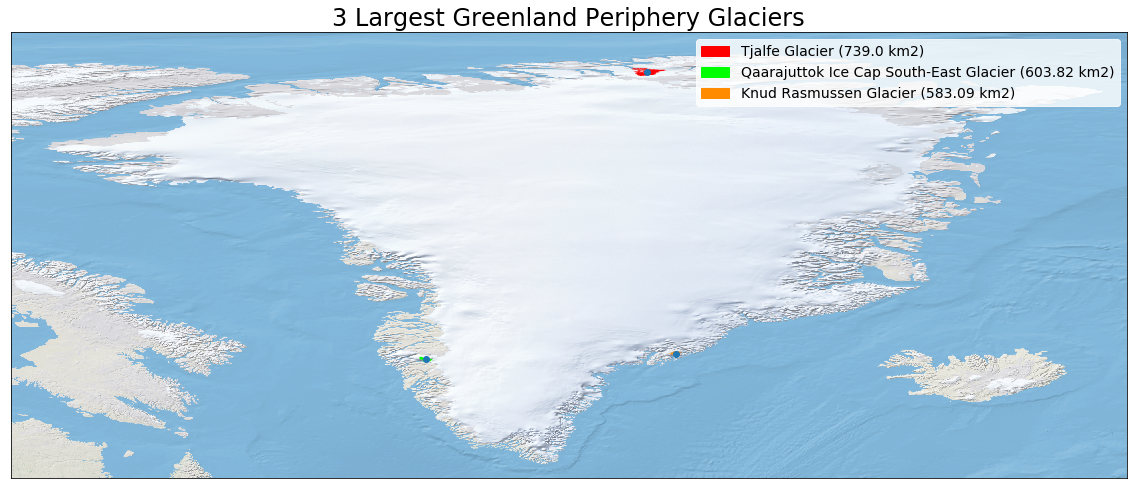

In [22]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)

# Plot the center points of the glacier complexes
centroidseries_gl.plot(ax=ax)

# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [40]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-5-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [24]:
# Open this regions ice caps from the exploded version
# Using RGI for this because we need the glacier connectivity information that is only in RGI
ice_caps_ex_fn = "data/rgi/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_clean_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [25]:
ice_caps_ex_df

id         area                                           geometry
0    527  9025.337793  POLYGON ((-19.40024197999998 81.07156655200004...
1  12487  4114.030297  POLYGON ((-38.57108542799995 82.22197577300005...
2    540  3466.028382  POLYGON ((-24.75460161099994 71.69292130500008...
3    515  3140.997594  POLYGON ((-68.16773301899997 76.74893880000008...
4    255  2243.480771  POLYGON ((-50.87457100399996 65.85541504600008...
5    338  2204.159032  POLYGON ((-26.88839166299994 70.95386414100005...
6  12544  2098.188398  POLYGON ((-36.79224905499996 82.97569166700004...
7    250  2074.663523  POLYGON ((-52.34600305199996 65.93798934600005...
8  12488  1846.473308  POLYGON ((-42.73753975899996 82.18804107100004...
9    252  1603.450612  POLYGON ((-36.73024922699994 65.96212787900004...

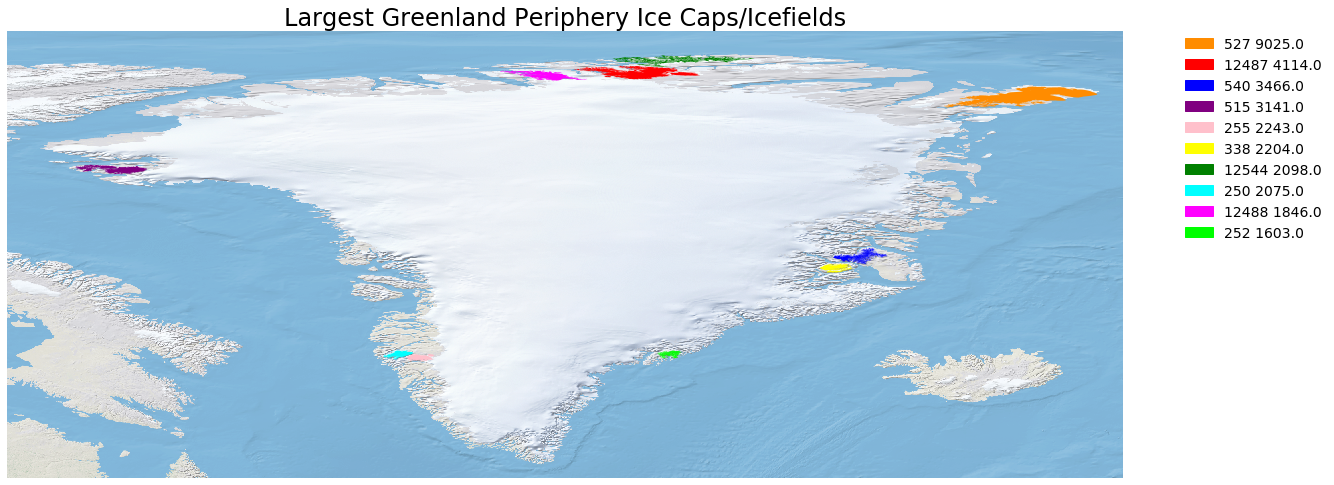

In [26]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
#legend_labels = ['Geikie Plateau (296)', 'Flade Isblink (11869)', 'Hans Tausen ice cap (11805)', 
#                 'Stauning Alps (12146)', 'Hutchinson Plateau (6719)', 'Unknown (4962)', 'The North Ice Cap (10909)', 
#                 'Renland Area (181)', 'Amitsulôq Ice Cap (4966)', 'Sukkertoppen Ice Cap (4963)']
legend_labels = [str(ice_caps_ex_df['id'][0]) + ' ' + str(round(ice_caps_ex_df['area'][0])), 
                 str(ice_caps_ex_df['id'][1]) + ' ' + str(round(ice_caps_ex_df['area'][1])), 
                 str(ice_caps_ex_df['id'][2]) + ' ' + str(round(ice_caps_ex_df['area'][2])), 
                 str(ice_caps_ex_df['id'][3]) + ' ' + str(round(ice_caps_ex_df['area'][3])),
                 str(ice_caps_ex_df['id'][4]) + ' ' + str(round(ice_caps_ex_df['area'][4])),
                 str(ice_caps_ex_df['id'][5]) + ' ' + str(round(ice_caps_ex_df['area'][5])),
                 str(ice_caps_ex_df['id'][6]) + ' ' + str(round(ice_caps_ex_df['area'][6])),
                 str(ice_caps_ex_df['id'][7]) + ' ' + str(round(ice_caps_ex_df['area'][7])),
                 str(ice_caps_ex_df['id'][8]) + ' ' + str(round(ice_caps_ex_df['area'][8])),
                 str(ice_caps_ex_df['id'][9]) + ' ' + str(round(ice_caps_ex_df['area'][9]))]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [27]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 3, 2]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Flade Isblink Glacier Complex',
                                      'Hans Tausen-Bure Glacier Complex',
                                      'Stauning Alps Glacier Complex',] 

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [28]:
# Open clean RGI shapefile with all of the glacier outlines
# Use region_no equal to 20 to access the clean RGI file (the one without glaciers of connectivity 2)
rgi_all_glaciers_df = ws.open_rgi_region(20)

In [29]:
rgi_all_glaciers_df.head()

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-05.00001  G306709E66077N  20000814  -9999999 -53.2909  66.0765   
1  RGI60-05.00002  G307930E65362N  20000823  -9999999 -52.0705  65.3617   
2  RGI60-05.00003  G307998E65579N  20000823  -9999999 -52.0017  65.5791   
3  RGI60-05.00004  G308201E65159N  20000823  -9999999 -51.7992  65.1590   
4  RGI60-05.00005  G308277E65179N  20000823  -9999999 -51.7228  65.1786   

  O1Region O2Region   Area  Zmin  ...  Aspect  Lmax  Status  Connect  Form  \
0        5        1  0.168   689  ...      25   406       0        0     0   
1        5        1  0.118   602  ...      49   283       0        0     0   
2        5        1  0.059   646  ...      28   365       0        0     0   
3        5        1  0.188   635  ...      30   392       0        0     0   
4        5        1  0.086   711  ...       1   218       0        0     0   

   TermType  Surging  Linkages  Name  \
0         0        9         9  None   
1         0        9         9  None   
2         0        9         9  None   
3         0        9         9  None   
4         0        9         9  None   

                                            geometry  
0  POLYGON ((-53.28803145099994 66.07926785100005...  
1  POLYGON ((-52.07906949999995 65.36133248300007...  
2  POLYGON ((-52.00295997799998 65.58098092600005...  
3  POLYGON ((-51.81231191599994 65.16057068500004...  
4  POLYGON ((-51.72386980199997 65.17986663300007...  

[5 rows x 23 columns]

In [30]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from shapefiles, set to 1 to run pip command

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
    largest_ic_1_glaciers = rgi_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['BgnDate'].min()
largest_ic_1_max_date = largest_ic_1_glaciers['BgnDate'].max()
# Format date to YYYY-MM-DD
largest_ic_1_min_date = largest_ic_1_min_date[0:4] + '-' + largest_ic_1_min_date[4:6] + '-' + \
                        largest_ic_1_min_date[6:8]
largest_ic_1_max_date = largest_ic_1_max_date[0:4] + '-' + largest_ic_1_max_date[4:6] + '-' + \
                        largest_ic_1_max_date[6:8]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ic_1_glims_ids = largest_ic_1_glaciers['GLIMSId']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
    largest_ic_2_glaciers = rgi_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['BgnDate'].min()
largest_ic_2_max_date = largest_ic_2_glaciers['BgnDate'].max()
# Format date to YYYY-MM-DD
largest_ic_2_min_date = largest_ic_2_min_date[0:4] + '-' + largest_ic_2_min_date[4:6] + '-' + \
                        largest_ic_2_min_date[6:8]
largest_ic_2_max_date = largest_ic_2_max_date[0:4] + '-' + largest_ic_2_max_date[4:6] + '-' + \
                        largest_ic_2_max_date[6:8]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
largest_ic_2_glims_ids = largest_ic_2_glaciers['GLIMSId']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
    largest_ic_3_glaciers = rgi_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_3_min_date = largest_ic_3_glaciers['BgnDate'].min()
largest_ic_3_max_date = largest_ic_3_glaciers['BgnDate'].max()
# Format date to YYYY-MM-DD
largest_ic_3_min_date = largest_ic_3_min_date[0:4] + '-' + largest_ic_3_min_date[4:6] + '-' + \
                        largest_ic_3_min_date[6:8]
largest_ic_3_max_date = largest_ic_3_max_date[0:4] + '-' + largest_ic_3_max_date[4:6] + '-' + \
                        largest_ic_3_max_date[6:8]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_glims_ids = largest_ic_3_glaciers['GLIMSId']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]

Reading file data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-5-1st-largest-ic-glacier-outlines.shp
1st largest start date: 2001-07-03
1st largest end date: 2001-07-03

Reading file data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-5-2nd-largest-ic-glacier-outlines.shp
2nd largest start date: 1999-99-99
2nd largest end date: 1999-99-99

Reading file data/rgi/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-5-3rd-largest-ic-glacier-outlines.shp
3rd largest start date: 2000-08-19
3rd largest end date: 2001-08-20



In [31]:
# Find the centroid of the glacier complex and add the lat/lon to the dataframe
centroidseries = final_catchment_data_df['geometry'].centroid

In [32]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add lat/lon
final_catchment_data_df['cenlat'] = [centroidseries.geometry.y[0], centroidseries.geometry.y[1], 
                                     centroidseries.geometry.y[2]]
final_catchment_data_df['cenlon'] = [centroidseries.geometry.x[0], centroidseries.geometry.x[1], 
                                     centroidseries.geometry.x[2]]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                   'min_date', 'max_date', 'cenlat', 'cenlon', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [33]:
final_catchment_data_df

region_no             reg_name                           ic_name  \
0         5  Greenland Periphery     Flade Isblink Glacier Complex   
1         5  Greenland Periphery  Hans Tausen-Bure Glacier Complex   
2         5  Greenland Periphery     Stauning Alps Glacier Complex   

   primeclass     area_km2    min_date    max_date     cenlat     cenlon  \
0           2  9025.337793  2001-07-03  2001-07-03  81.209334 -15.639075   
1           3  4114.030297  1999-99-99  1999-99-99  82.606117 -38.189800   
2           2  3466.028382  2000-08-19  2001-08-20  71.887344 -25.366133   

                                            geometry  
0  POLYGON ((-19.40024197999998 81.07156655200004...  
1  POLYGON ((-38.57108542799995 82.22197577300005...  
2  POLYGON ((-24.75460161099994 71.69292130500008...

### Plot the final catchment dataframe to verify it looks correct

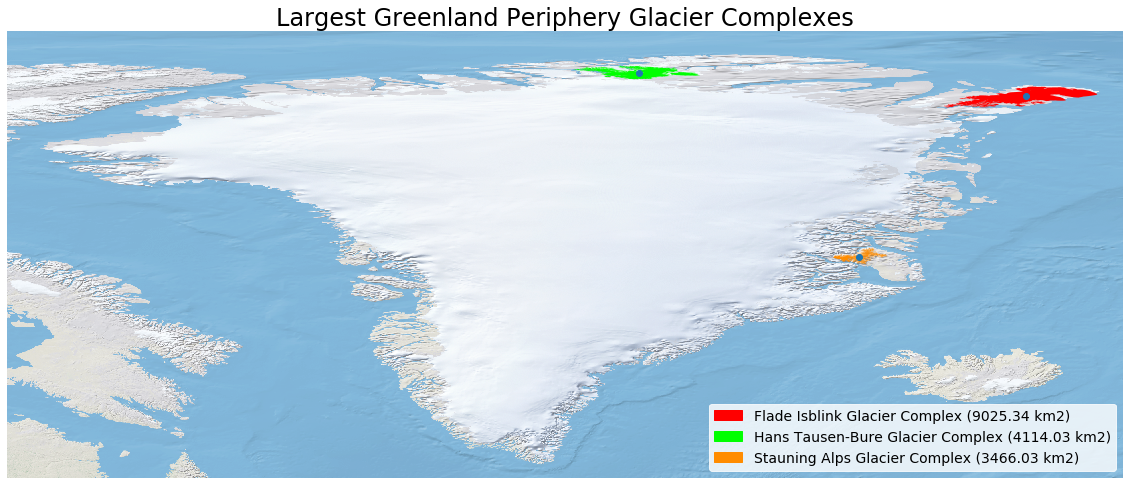

In [38]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Plot the center points of the glacier complexes
centroidseries.plot(ax=ax)

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         loc="lower right")

plt.show()

### Save final catchment dataframe to a shapefile

In [39]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-5-largest-complexes.zip


In [36]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

data/final-dataset/region-5-1st-largest-glims-ids.txt already extists
data/final-dataset/region-5-2nd-largest-glims-ids.txt already extists
data/final-dataset/region-5-3rd-largest-glims-ids.txt already extists
data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-5-1st-largest-ic-glacier-outlines.zip already extists
data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-5-2nd-largest-ic-glacier-outlines.zip already extists
data/rgi/processed/ice-caps/largest/individual-glacier-outlines/region-5-3rd-largest-ic-glacier-outlines.zip already extists


### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

After perporming the analysis below, no buffer adjustment needed for Region 5.

In [37]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

Stopping notebook.


#### Check 1st largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['Area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['Area'].sum()
if (abs(area_diff_1)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_1_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

#### Check 2nd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['Area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['Area'].sum()
if (abs(area_diff_2)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    #acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_2_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax, color='blue')

#### Check 3rd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines 
# acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['Area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['Area'].sum()
if (abs(area_diff_3)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = 0
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_3_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax, color='blue')

## Clipping Ice Caps

Going to go with Flade Isblink as the largest ice cap followed by Hans Tausen. Note Hans Tausen is the northern most ice cap in the world. 

The Stauning Alps do not appear to be covered in an ice cap and neither are the Geikie Plateau or Hutchinson Plateau(according to Satellite Image Atlas of Glaciers of the World - Greenland (Weidick, 1995), these are "areas"), so I think the next biggest one is the North Ice Cap. 

Will use the Flade Isblink polygon from the GLIMS database (ID G344790E81287N). Bolch et al (2013) give a size of ~7,500 km^2 and I have it at 7,538 km^2. Will need to clip the Hans Tausen ice cap since it picked up some extra ice during the "explode" operation. It looks like it contains Bure Ice Cap as well (Landvik et al 2001) but that ref gives the size at 4,200 km^2 and the size if have hear is 4,117 km^2. I think the North Ice Cap looks good based on Greenland Plate 1 (Weidick, 1995).

August 2021: Per review from my co-authors, have decided to not clip ice caps. I'm keeping this code for provenance. 

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

### Clip Bure Ice Cap away from Hans Tausen Ice Cap

In [ ]:
# Create a clipping polygon for Hans Tausen Ice Cap
# Create dataframe that holds the clipping box
hans_area_points = Polygon([(-42.7752, 82.7661), (-39.8419, 83.0774),
                            (-35.6232, 82.8827), (-35.9088, 82.6475), 
                            (-36.4581, 82.5570), (-36.3675, 82.4686),
                            (-35.8209, 82.3901), (-39.4464, 81.9671),
                            (-42.7752, 82.7661)])

hans_gdf = gpd.GeoDataFrame([1],
                            geometry=[hans_area_points],
                            crs={'init': 'epsg:' + ic_epsg})

hans_ex_ic_index = ice_caps_ex_df[ice_caps_ex_df['id']==12487].index.values
hans_ex_ic_df = cl.clip_shp(ice_caps_ex_df.iloc[hans_ex_ic_index[0]:hans_ex_ic_index[0]+1], hans_gdf)
hans_ex_ic_df.reset_index(drop=True, inplace=True)

In [ ]:
hans_ex_ic_df

In [ ]:
# Determine area of this clipped Hans Tausen ice cap
hans_ex_area = hans_ex_ic_df['geometry'].to_crs({'init': 'epsg:' + ic_epsg}).area/10**6
round(hans_ex_area[0], 6)

In [ ]:
# Plot the new Hans Tausen Ice Cap to see if it is correct
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
hans_ex_ic_df.plot(ax=ax, color="darkorange")
ax.set_title('Hans Tausen Ice Caps', fontsize=24)
ax.set_axis_off()

plt.show()

In [ ]:
# Write dataframe to shapefile and save to zip so I can review it in ArcMap
hans_zipfile_fn = "data/glims/processed/ice-caps/exploded/region-" + region_number + "-hans-tausen-clip.zip"
if os.path.exists(hans_zipfile_fn) == False:
    # Create the shapefile
    hans_data_fn = "data/glims/processed/ice-caps/exploded/region-" + region_number + "-hans-tausen-clip.shp"
    hans_ex_ic_df.to_file(driver='ESRI Shapefile', filename=hans_data_fn)
    
    # Zip up the shapefile
    hans_zipfile_fn = ws.zipshp(hans_data_fn, Delete=True)
    print("Creating zipfile: " + hans_zipfile_fn)
else:
    print(hans_zipfile_fn + " already extists")

In [ ]:
# Open the RGI largest glaciers which contains Flade Isblink
# Have to do this since now only interested in glacier with connectivity 0 or 1 in the glacier analysis
# However, when this file was created, wasn't filtering for that, so Flade Isblink is part of this shapefile
rgi_glaciers_lg_fn = "data/rgi/processed/largest/rgi_region_5_largest.shp"
rgi_glaciers_lg_df = gpd.read_file(rgi_glaciers_lg_fn)

# Rename the Area column
rgi_glaciers_lg_df.rename(columns={'Area': 'area'}, inplace=True)

### Set up Ice Cap data frame

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_clipped_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop uneeded rows: first 6 and last 3 rows because only keeping North Ice cap
final_clipped_catchment_data_df.drop([0, 1, 2, 4, 5, 6, 7, 8, 9], inplace = True)

# Stop notebook here. The next section is not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass
#raise StopExecution


# Add Flade Isblink from the glacier dataframe
final_clipped_catchment_data_df = final_clipped_catchment_data_df.append(
                                  rgi_glaciers_lg_df.iloc[0:1].drop(['RGIId', 'GLIMSId', 
                                                                       'EndDate', 'CenLon',
                                                                       'CenLat', 'O1Region',
                                                                       'O2Region', 'Zmin',
                                                                       'Zmax', 'Zmed', 'Slope',
                                                                       'Aspect', 'BgnDate',
                                                                       'Lmax', 'Status',
                                                                       'Connect', 'Form',
                                                                       'TermType', 'Surging',
                                                                       'Linkages', 'Name'], axis=1))

# Add Hans Tausen dataframe and update its area measurement
final_clipped_catchment_data_df = final_clipped_catchment_data_df.append(hans_ex_ic_df.drop(['id'], axis=1))
final_clipped_catchment_data_df.iloc[2, final_clipped_catchment_data_df.columns.get_loc('area')] = round(hans_ex_area[0], 6)

# Add region_no column
final_clipped_catchment_data_df['region_no'] = region_number

# Add region_name column
final_clipped_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_clipped_catchment_data_df['primeclass'] = [3, 3, 3]

# Sort the dataframe by largest to smallest ice cap
final_clipped_catchment_data_df = final_clipped_catchment_data_df.sort_values(by = "area", ascending = False)

# Add catchment names
final_clipped_catchment_data_df['ic_name'] = ['Flade Isblink', 'Hans Tausen Ice Cap', 'North Ice Cap']

In [ ]:
final_clipped_catchment_data_df

### Get ice catchment measurement dates from a range of glacier outline dates.

Note that for Flade Isblink we can just take the single date straight from the GLIMS database because it is aready the true outline of that ice cap.

In [ ]:
# Set the min and max date for Flade Isblink from the GLIMS largest database value
flade_glaciers_min_date = rgi_glaciers_lg_df.iloc[0:1]['BgnDate'][0]
flade_glaciers_max_date = rgi_glaciers_lg_df.iloc[0:1]['BgnDate'][0]
flade_glaciers_min_date = flade_glaciers_min_date[0:4] + '-' + flade_glaciers_min_date[4:6] + '-' + \
                          flade_glaciers_min_date[6:8]
flade_glaciers_max_date = flade_glaciers_max_date[0:4] + '-' + flade_glaciers_max_date[4:6] + '-' + \
                          flade_glaciers_max_date[6:8]
print('flade start date: ' + flade_glaciers_min_date)
print('flade end date: ' + flade_glaciers_max_date)
print('')
all_fla_ids = rgi_glaciers_lg_df.iloc[0:1]['GLIMSId'][0]

# Get glaciers on Hans Tausen Ice Cap
hans_ic_mask = ws.pip(rgi_all_glaciers_df, hans_ex_ic_df.reset_index(drop=True))
hans_glaciers = rgi_all_glaciers_df.loc[hans_ic_mask]
hans_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
hans_glaciers_min_date = hans_glaciers['BgnDate'].min()
hans_glaciers_max_date = hans_glaciers['BgnDate'].max()
# Format date to YYYY-MM-DD
hans_glaciers_min_date = hans_glaciers_min_date[0:4] + '-' + hans_glaciers_min_date[4:6] + '-' + \
                         hans_glaciers_min_date[6:8]
hans_glaciers_max_date = hans_glaciers_max_date[0:4] + '-' + hans_glaciers_max_date[4:6] + '-' + \
                         hans_glaciers_max_date[6:8]
print('hans start date: ' + hans_glaciers_min_date)
print('hans end date: ' + hans_glaciers_max_date)
print('')

# Get all glims ids that make up the hans ice catchment
han_glims_ids = hans_glaciers['GLIMSId']
for i in range(len(han_glims_ids)):
    if i == 0:
        all_han_ids = han_glims_ids[i]
    else:
        all_han_ids = all_han_ids + ', ' + han_glims_ids[i]

# Get glaciers on North Ice Cap
north_ic_mask = ws.pip(rgi_all_glaciers_df, ice_caps_ex_df.iloc[6:7].reset_index(drop=True))
north_glaciers = rgi_all_glaciers_df.loc[north_ic_mask]
north_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
north_glaciers_min_date = north_glaciers['BgnDate'].min()
north_glaciers_max_date = north_glaciers['BgnDate'].max()
north_glaciers_min_date = north_glaciers_min_date[0:4] + '-' + north_glaciers_min_date[4:6] + '-' + \
                          north_glaciers_min_date[6:8]
north_glaciers_max_date = north_glaciers_max_date[0:4] + '-' + north_glaciers_max_date[4:6] + '-' + \
                          north_glaciers_max_date[6:8]
print('north start date: ' + north_glaciers_min_date)
print('north end date: ' + north_glaciers_max_date)
print('')

# Get all glims ids that make up the north ice catchment
nor_glims_ids = north_glaciers['GLIMSId']
for i in range(len(nor_glims_ids)):
    if i == 0:
        all_nor_ids = nor_glims_ids[i]
    else:
        all_nor_ids = all_nor_ids + ', ' + nor_glims_ids[i]

In [ ]:
# Add the dates to the dataframe
final_clipped_catchment_data_df['min_date'] = [flade_glaciers_min_date, hans_glaciers_min_date, north_glaciers_min_date]

final_clipped_catchment_data_df['max_date'] = [flade_glaciers_max_date, hans_glaciers_max_date, north_glaciers_max_date]

# Add the GLIMS IDS
final_clipped_catchment_data_df['glims_ids'] = [all_fla_ids, all_han_ids, all_nor_ids]

# Reorder the columns
final_clipped_catchment_data_df = final_clipped_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                                   'min_date', 'max_date', 'glims_ids', 'geometry']]
# Rename the area column
final_clipped_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_clipped_catchment_data_df = final_clipped_catchment_data_df.reset_index(drop=True)

In [ ]:
final_clipped_catchment_data_df

### Plot the final catchment dataframe to verify it looks correct

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_clipped_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_clipped_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_clipped_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_clipped_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_clipped_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_clipped_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_clipped_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_clip_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes-clipped.zip"
if os.path.exists(catchment_clip_zipfile_fn) == False:
    # Create the shapefile
    final_clipped_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes-clipped.shp"
    final_clipped_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_clipped_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_clip_zipfile_fn = ws.zipshp(final_clipped_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_clip_zipfile_fn)
else:
    print(catchment_clip_zipfile_fn + " already extists")

In [ ]:
# Stop notebook here. The next section is not needed.
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
raise StopExecution

## Using GLIMS

Not going to use GLIMS because need the connectivity data that is in RGI but leaving this code for provenance.

In [ ]:
# Open this regions ice caps from the exploded version
ice_caps_glims_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                        region_number + "_epsg" + ic_epsg + ".shp"
ice_caps_glims_ex_df = gpd.read_file(ice_caps_ex_fn)

In [ ]:
ice_caps_glims_ex_df

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
#legend_labels = ['Geikie Plateau (296)', 'Flade Isblink (11869)', 'Hans Tausen ice cap (11805)', 
#                 'Stauning Alps (12146)', 'Hutchinson Plateau (6719)', 'Unknown (4962)', 'The North Ice Cap (10909)', 
#                 'Renland Area (181)', 'Amitsulôq Ice Cap (4966)', 'Sukkertoppen Ice Cap (4963)']
legend_labels = [str(ice_caps_glims_ex_df['id'][0]) + ' ' + str(round(ice_caps_glims_ex_df['area'][0])), 
                 str(ice_caps_glims_ex_df['id'][1]) + ' ' + str(round(ice_caps_glims_ex_df['area'][1])), 
                 str(ice_caps_glims_ex_df['id'][2]) + ' ' + str(round(ice_caps_glims_ex_df['area'][2])), 
                 str(ice_caps_glims_ex_df['id'][3]) + ' ' + str(round(ice_caps_glims_ex_df['area'][3])),
                 str(ice_caps_glims_ex_df['id'][4]) + ' ' + str(round(ice_caps_glims_ex_df['area'][4])),
                 str(ice_caps_glims_ex_df['id'][5]) + ' ' + str(round(ice_caps_glims_ex_df['area'][5])),
                 str(ice_caps_glims_ex_df['id'][6]) + ' ' + str(round(ice_caps_glims_ex_df['area'][6])),
                 str(ice_caps_glims_ex_df['id'][7]) + ' ' + str(round(ice_caps_glims_ex_df['area'][7])),
                 str(ice_caps_glims_ex_df['id'][8]) + ' ' + str(round(ice_caps_glims_ex_df['area'][8])),
                 str(ice_caps_glims_ex_df['id'][9]) + ' ' + str(round(ice_caps_glims_ex_df['area'][9]))]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_glims_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_glims_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_glims_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_glims_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_glims_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_glims_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_glims_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_glims_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_glims_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_glims_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [ ]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_glims_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 3, 2]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Geikie Plateau Glacier Complex', 
                                      'Flade Isblink Glacier Complex',
                                      'Stauning Alps Glacier Complex',] 

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [ ]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [ ]:
# This section took about 1.5 hours to run so hard codoing the info to variables and commenting out the code. 
# To rerun, uncomment the code
# Get glaciers in the 1st largest glacier complex
#largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_glims_ex_df.iloc[0:1].reset_index(drop=True))
#largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
#largest_ic_1_glaciers.reset_index(drop=True, inplace=True)

# Clean and print the minimum date and the maximum date
#largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
#largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
largest_ic_1_min_date = '1995-12-16'
largest_ic_1_max_date = '2002-09-05'
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
#largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
#for i in range(len(largest_ic_1_glims_ids)):
#    if i == 0:
#        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
#    else:
#        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-1st-largest-glims-ids.txt') as f:
    ids = f.readlines()
    all_largest_ic_1_ids = ids[0]

# Get glaciers in the 2nd largest glacier complex
#largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_glims_ex_df.iloc[1:2].reset_index(drop=True))
#largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
#largest_ic_2_glaciers.reset_index(drop=True, inplace=True)

# Clean and print the minimum date and the maximum date
#largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
#largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
largest_ic_2_min_date = '2003-07-01'
largest_ic_2_max_date = '2003-07-01'
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
#largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
#for i in range(len(largest_ic_2_glims_ids)):
#    if i == 0:
#        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
#    else:
#        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-2nd-largest-glims-ids.txt') as f:
    ids = f.readlines()
    all_largest_ic_2_ids = ids[0]


# Get glaciers in the 3rd largest glacier complex
#largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_glims_ex_df.iloc[2:3].reset_index(drop=True))
#largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
#largest_ic_3_glaciers.reset_index(drop=True, inplace=True)

# Clean and print the minimum date and the maximum date
#largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
#largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
largest_ic_3_min_date = '2000-08-19'
largest_ic_3_max_date = '2001-08-20'
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
#largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
#for i in range(len(largest_ic_3_glims_ids)):
#    if i == 0:
#        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
#    else:
#        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]
with open('data/glims/processed/ice-caps/largest/region-' + region_number + '-3rd-largest-glims-ids.txt') as f:
    ids = f.readlines()
    all_largest_ic_3_ids = ids[0]

In [ ]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add the GLIMS IDS
final_catchment_data_df['glims_ids'] = [all_largest_ic_1_ids, all_largest_ic_2_ids, all_largest_ic_3_ids]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                   'min_date', 'max_date', 'glims_ids', 'geometry']]

# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [ ]:
final_catchment_data_df

### Plot the final catchment dataframe to verify it looks correct

In [ ]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         loc="lower right")

plt.show()

### Save final catchment dataframe to a shapefile

In [ ]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glims-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-glims-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

In [ ]:
# Save the glims ids to a text file because it took a couple of hours to run the id selection code
text_file_1st_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/glims/processed/ice-caps/largest/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")

## Compute area of the clipped ice caps with an equal area projection

In [ ]:
# Open this regions clipped ice caps
ice_caps_clipped_fn = "data/final-dataset/old/region-5-largest-complexes-clipped/region-5-largest-complexes-clipped.shp"
ice_caps_clipped_df = gpd.read_file(ice_caps_clipped_fn)

In [ ]:
ice_caps_clipped_df

In [ ]:
crs_code = "+proj=laea"
hans_tausen_area = ice_caps_clipped_df.iloc[1:2]['geometry'].to_crs(crs_code).area/10**6
hans_tausen_area